## 实现线性回归

### 使用Tensor和autograd来实现一个线性回归，具体的步骤有：
* 生成和读取数据集
* 构建模型
* 初始化模型参数
* 定义损失函数和优化算法
* 训练模型

### 导入本次实验所需的包或模块，其中matplotlib包可用于作图，用来显示生成的数据的二维图。


In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

## 生成数据

### 本实验先构造一个简单训练数据集，通过这个数据集可以直观的比较模型训练出来的参数和真实的模型参数的区别。设训练数据集样本数为1000，输入个数（特征数）为2，给定随机生成的批量样本特征X∈R^1000×2。这里使用线性回归模型的真实权重w=[2，-3.4].T和偏差b=4.2，以及一个随机噪声项e来生成标签。  
  
### y=xw.T+b+e

### 其中，噪声项e是服从均值0、标准差为0.01的正态分布。噪声代表了数据中无意义的干扰。

In [3]:
num_inputs = 500
num_examples = 10000
true_w = 0.0056 
true_b = 0.028
features = torch.tensor(np.random.normal(0,1,(num_examples,num_inputs)),dtype=torch.float)
labels = true_w*features.sum(dim=1)+true_b
labels += torch.tensor(np.random.normal(0,0.001,size=labels.size()),dtype=torch.float)

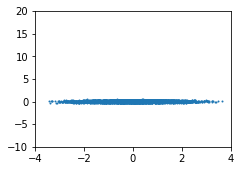

In [6]:
plt.figure(figsize=(3.5,2.5))
plt.xlim(-4,4)
plt.ylim(-10,20)
plt.scatter(features[:,1].numpy(),labels.numpy(),1)

## 读取数据

### 在模型训练的时候，需要遍历数据集并不断读取下批量的数据样本。这里本实验定义一个函数`data_iter()` 它每次返回batch_size（批量大小）个随机样本的特征与标签。

In [7]:
num_inputs = 500
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) #样本的读取顺序是随机的
    for i in range(0,num_examples,batch_size):
#         print(i)
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])# 最后一次可能不足一个batch
        yield features.index_select(0,j),labels.index_select(0,j)

## 构建模型

### 在构建模型之前，需要将权重和偏置初始化。本实验将权重初始化成均值为0、标准差为0.01的正态随机数，偏置初始化为0.

In [17]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)

### 在后面的模型训练中，需要对这些参数求梯度来迭代参数的值，  
### 因此要设置requires_grad = True

In [18]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

### 下面使用mm()函数做矩阵乘法，来实现线性回归的模型

In [10]:
def linreg(X,w,b):
    return torch.mm(X,w)+b

## 损失函数和优化算法

### 本实验使用平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat形状。以下的函数返回的结果和y_hat的形状相同。

In [11]:
def squared_loss(y_hat,y):
    return (y_hat-y.view(y_hat.size()))**2/2

### 以下的sgd函数实现了小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得到的是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [12]:
def sgd(params,lr,batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size

## 手动实现线性回归

## 模型训练

### 在训练过程中，模型将会多次迭代更新参数。在每次迭代中，根据当前读取的小批量数据样本（特征x和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。

In [19]:
lr = 0.001
num_epochs = 10
net = linreg
loss = squared_loss
batch_size = 100
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features,w,b),labels)
    print('epoch%d,loss%f'%(epoch+1,train_l.mean().item()))

epoch1,loss0.031239
epoch2,loss0.025239
epoch3,loss0.020433
epoch4,loss0.016578
epoch5,loss0.013477
epoch6,loss0.010980
epoch7,loss0.008963
epoch8,loss0.007332
epoch9,loss0.006010
epoch10,loss0.004936


In [13]:
print(true_w,'\n',w)
print(true_b,'\n',b)

[2, -3.4] 
 tensor([[ 1.9982],
        [-3.3937]], requires_grad=True)
4.2 
 tensor([4.1927], requires_grad=True)


## 利用torch.nn实现线性回归

### 读取数据

* PyTorch提供了data库来读取数据。由于data常用作变量名，这里将导入的data模块用Data代替。对前面的读取数据部分可以使用data库来处理。在每一次迭代中，使用Data随机读取包含10个数据样本的小批量。

In [15]:
import torch.utils.data as Data
batch_size = 100
lr = 0.3
# 将训练数据的特征和标签组合
dataset = Data.TensorDataset(features,labels)

# 把dataset放入DataLoader
data_iter = Data.DataLoader(
            dataset = dataset,
            batch_size = batch_size,
            shuffle = True)

### 构建模型

* 构建模型的过程中，最常见的方法就是继承nn.Module，然后构建自己的网络。一个nn.Module实例需要包含一些层以及返回输出的前向传播方法。下面利用nn.Module构建一个线性回归模型

In [40]:
import torch.nn as nn
class LinearNet(nn.Module):
    def __init__(self,n_feature):
        super(LinearNet,self).__init__()
        self.linear = nn.Linear(n_feature,1)
    
    def forward(self,x):
        y = self.linear(x)
        return y
    
net = LinearNet(num_inputs)

### 模型参数初始化

* 在使用定义的模型net之前，需要对模型中的一些参数进行初始化。Pytorch在init模块中提供了许多初始化参数的方法。我们可以调用init.normal模块通过正态分布对线性回归中的权重和偏差进行初始化

In [41]:
from torch.nn import init

init.normal_(net.linear.weight,mean=0,std=0.01)
init.constant_(net.linear.bias,val=0) #也可以直接修改bias的data：net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

### 损失函数和优化

* Pytorch在torch.nn中提供了各种损失函数，这些损失函数实现为nn.Module的子类，可以将这些损失函数作为一种特殊的层。

In [42]:
loss = nn.MSELoss()

* Pytorch在torch.optim模块中提供了诸如SGD，Adam和RMSProop等优化算法。本例将使用小批量随机梯度下降算法进行优化。

In [44]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(),lr=0.03)

# 可以为不同的子网络设置不同学习率
# optimizer = optim.SGD([
#     # 如果不指定学习率，则会默认使用最外层学习率
#     {'params': net.subnet1.parameters()}
#     {'params': net.subnet2.parameters(),'lr':0.01}
# ],lr=0.03)

### 模型训练

* 训练模型时，可以调用optim中的step()函数来迭代模型参数。按照小批量随机梯度下降的定义，在step()函数中指定批量大小，从而对批量中的样本梯度求平均。

In [51]:
num_epochs = 3
for epoch in range(1,num_epochs+1):
    for X,y in data_iter:
        output = net(X)
        l = loss(output,y.view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d,loss: %f'%(epoch,l.item()))

epoch 1,loss: 0.000083
epoch 2,loss: 0.000090
epoch 3,loss: 0.000082


## 模型预测及评价（分类问题）

* 对于分类问题，给定任一样本特征，模型可以预测每个输出类别的概率。通常，我们把预测概率最大的类别作为输出类别。如果它与真实类别(标签)一致，说明这次预测时正确的。我们使用准确率(accuracy)来评价模型的表现。它等于正确实现预测数量与总预测数量之比。

* 下面我们给出准确率计算函数的实现

In [52]:
def accuracy(y_hat,y):
    return (y_hat.argmax(dim=1)==y).float().mean().item()

* 评价模型net在数据集data_itear上的准确率

In [53]:
def evaluate_accuracy(data_iter,net):
    acc_sum,n = 0.0,0
    for X,y in data_iter:
        acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        n += y.shape[0]
    return acc_sum/n